# The Stopping and Range of Ions in Matter  (SRIM) post processing

## Requirments

- Python 3 notebook
- numpy
- matplotlib
- ipywidgets extention for interactive analysis

python modules to install

```
$ pip install --user ipympl 
$ pip install --user ipyfilechooser
```


## main parsing code

In [1]:
import re
import string
import math

from numpy import *

DELIMER = '<#>'
UNICODE_DEAD_SYMBOL = '\ufffd'
ASCII_DEAD_SYMBOL = '?'
KeV_in_Mev = 1000

data_line_re = re.compile(".+\d+\.E\+0.*")
dead_line_re = re.compile(".*(Target|Replacements).*")

def get_data_lines(raw_line):
    return data_line_re.match(raw_line) and not dead_line_re.match(raw_line)

def line_to_record(data_line):

    data_line = data_line.replace(UNICODE_DEAD_SYMBOL, DELIMER).replace(ASCII_DEAD_SYMBOL, DELIMER)
    rf = data_line.split(DELIMER)

    record = {}
    record['ion'] = rf[1]
    record['energy'] = float(rf[2]) / KeV_in_Mev
    record['depth'] = float(rf[3])
    record['y'] = float(rf[4])
    record['z'] = float(rf[5])
    record['se'] = float(rf[6])
    record['atom'] = rf[7].strip()
    record['recoil_energy'] = float(rf[8])
    record['target_disp'] = float(rf[9])

    return record

def read_records(data_file):
    with open(data_file, mode = 'r', encoding="utf-8", errors="replace") as f:
        data_lines_only = filter(get_data_lines, f.readlines())
        records = map(line_to_record, data_lines_only)

        return sorted(records, key=lambda record: record['depth'])

def update_energy(e):
    (l, r) = e
    r['layer'] = l
    energies = array(r['energy'])
    avg = energies.mean()
    emin = min(r['energy'])
    var = average((energies - avg) ** 2)
    sigma = energies.std()
    err = math.sqrt(var) / math.sqrt(len(r['energy']))
    r['sigma'] = sigma
    r['avg'] = avg
    r['err'] = err
    r['count'] = len(r['energy'])
    return r

def process(filename):

    last_level = None
    level_index = -1
    levels = []

    for r in read_records(filename):
        atom = r['atom']
        if atom != last_level:
            level_index += 1
            last_level = atom
            levels.append({})
            levels[level_index]['atom'] = atom
            levels[level_index]['energy'] = []
            levels[level_index]['layer'] = level_index
            levels[level_index]['depth0'] = 1 << 63
            levels[level_index]['depth1'] = 0

        run_info = levels[level_index]

        if run_info['depth0'] > r['depth']:
            run_info['depth0'] = r['depth']
        if run_info['depth1'] < r['depth']:
            run_info['depth1'] = r['depth']

        run_info['energy'].append(r['energy'])

    final_lavels = filter(lambda record: record['depth1'] - record['depth0'] != 0, levels)
    final_lavels = map(update_energy, enumerate(final_lavels))

    return sorted(final_lavels, key = lambda record: record['layer'])


## Load data from secified file

In [15]:
from ipyfilechooser import FileChooser
import os

fc = FileChooser(
    os.getcwd(),
    filename='COLLISON.txt',
    title='<b>FileChooser COLLISION file</b>',
    show_hidden=False,
    select_default=True,
    use_dir_icons=True,
    show_only_dirs=False
)

display(fc)

filename = fc.get_interact_value()


FileChooser(path='/home/jovyan/work/eProjects/srim-pp', filename='COLLISON.txt')

In [33]:
filename = fc.get_interact_value()
data = process(filename)

## Interactive to visualize results

In [34]:
%matplotlib ipympl

<IPython.core.display.Javascript object>


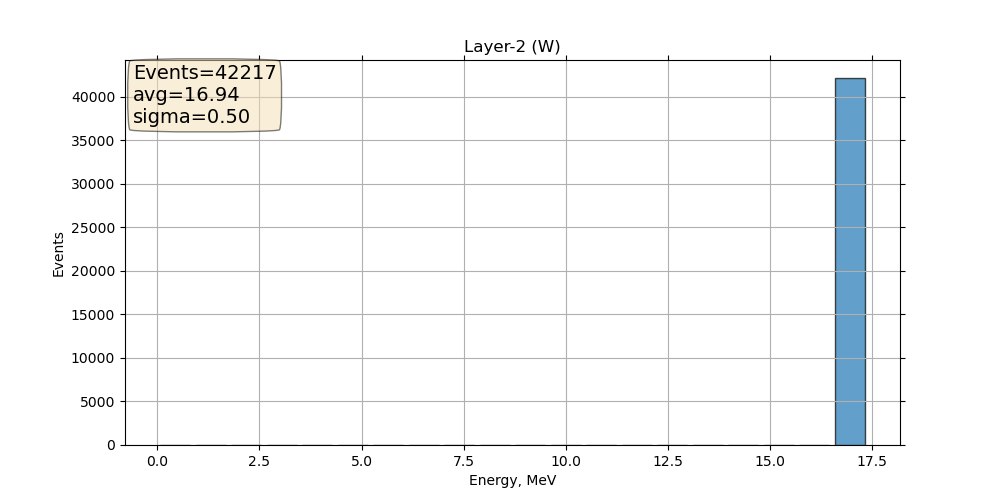

Dropdown(description='Layers:', options=('Layer-0 (Ti)', 'Layer-1 (Cu)', 'Layer-2 (W)', 'Layer-3 (Al)', 'Layer…

In [35]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)

fig = plt.figure()
plt.ion()
fig.show()
ax = fig.add_subplot(111)

layers = []
for i in range(len(data)):
    l = data[i]
    layers.append('Layer-%d (%s)' % (l['layer'], l['atom']))
    
def plot_layer(layer_index):
    
    layer_name = layers[layer_index]
    layer_data = data[layer_index]
    
    ax.cla()
    ax.set_xlabel('Energy, MeV')
    ax.set_ylabel('Events')
    ax.set_title(layer_name)
    ax.grid(True)

    n, bins, patches = ax.hist(layer_data['energy'], density=False, bins=20, linewidth=1, edgecolor='black', alpha=0.7, rwidth=0.85)

    textstr = 'Events=%d\navg=%.2f\nsigma=%.2f' % (len(layer_data['energy']), layer_data['avg'], layer_data['sigma'])
    props = dict(boxstyle='round4', facecolor='wheat', alpha=0.5)
    x, xx, y = ax.get_xlim()[0], ax.get_xlim()[1] - ax.get_xlim()[0], ax.get_ylim()[1]
    ax.text(x + xx/100, y - y/100, textstr, fontsize=14, verticalalignment='top', bbox=props)

    fig.canvas.draw()
    
def on_level_selection_change(change):
    if type(change.new) == int:
        layer_index = change.new
        plot_layer(layer_index)
    
selected_layer = widgets.Dropdown(
    options=layers,
    value=layers[0],
    description='Layers:',
    disabled=False,
)

plot_layer(0)
selected_layer.observe(on_level_selection_change)

display(selected_layer)

<IPython.core.display.Javascript object>


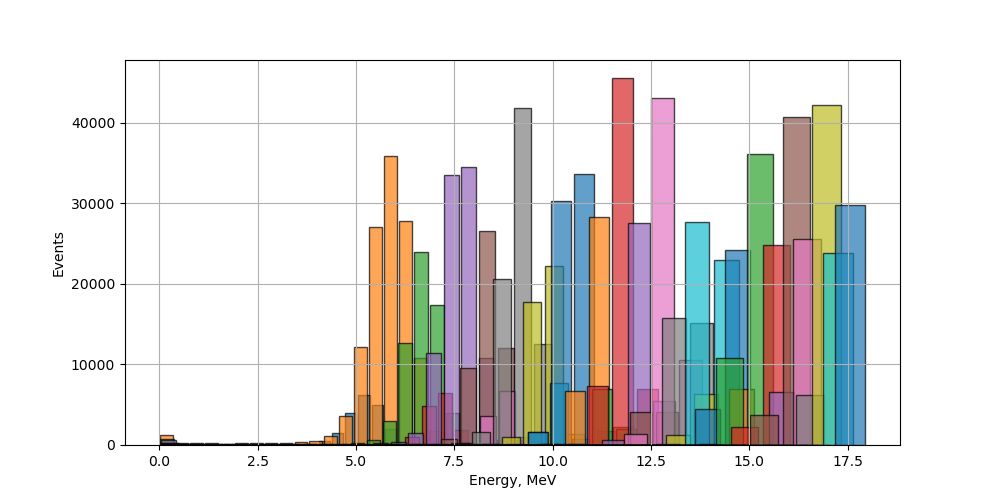

In [36]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
fig = plt.figure()
plt.ion()
fig.show()
ax = fig.add_subplot(111)
ax.set_xlabel('Energy, MeV')
ax.set_ylabel('Events')
ax.grid(True)

for i in range(len(data)):    
    n, bins, patches = ax.hist(data[-i - 1]['energy'], density=False, bins=20, linewidth=1, edgecolor='black', alpha=0.7, rwidth=0.85)
    fig.canvas.draw()
    
